# **Analysis of Estimation Errors in Portfolio Optimization**

## This notebook analyzes the impact of estimation errors in means, variances, and covariances on portfolio optimization results. We'll use historical data to create a base portfolio and then simulate various types of estimation errors to understand their effects on portfolio performance.


In [15]:
import sys
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import default_rng
import logging

project_root = Path.cwd().parent
sys.path.append(str(project_root))

# Import custom modules
from src.data_management import DataManager
from src.portfolio_optimizer import PortfolioParameters, create_base_portfolio
from src.error_analysis import ErrorAnalysisConfig, run_error_analysis
from src.visualization import PortfolioVisualizer

In [16]:
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

## 1. Data Collection and Processing
First, we'll define our universe of stocks (DJIA constituents) and randomly select 10 of them.


In [17]:
djia_constituents = [
    'AAPL',  # Apple
    'AMGN',  # Amgen
    'AXP',   # American Express
    'BA',    # Boeing
    'CAT',   # Caterpillar
    'CRM',   # Salesforce
    'CSCO',  # Cisco
    'CVX',   # Chevron
    'DIS',   # Disney
    'DOW',   # Dow Inc.
    'GS',    # Goldman Sachs
    'HD',    # Home Depot
    'HON',   # Honeywell
    'IBM',   # IBM
    'INTC',  # Intel
    'JNJ',   # Johnson & Johnson
    'JPM',   # JPMorgan Chase
    'KO',    # Coca-Cola
    'MCD',   # McDonald's
    'MMM',   # 3M
    'MRK',   # Merck
    'MSFT',  # Microsoft
    'NKE',   # Nike
    'PG',    # Procter & Gamble
    'TRV',   # Travelers
    'UNH',   # UnitedHealth
    'V',     # Visa
    'VZ',    # Verizon
    'WBA',   # Walgreens Boots Alliance
    'WMT',   # Walmart
]

# Set random seed for reproducibility
rng = default_rng(42)

# Randomly select 10 stocks
selected_symbols = sorted(rng.choice(djia_constituents, size=10, replace=False))

print("Selected Stocks:")
for symbol in selected_symbols:
    print(f"- {symbol}")


Selected Stocks:
- AMGN
- AXP
- CRM
- GS
- JNJ
- KO
- MMM
- NKE
- TRV
- WMT


In [18]:
# Initialize DataManager
data_manager = DataManager(
    symbols=selected_symbols,
    start_date='2014-01-01',  # Using 5 years of data
    end_date='2023-12-31',
    data_dir='../data'
)

# Process data
statistics = data_manager.process_all()

# Print basic statistics
print("\nPortfolio Components Statistics:")
for i, symbol in enumerate(selected_symbols):
    print(f"\n{symbol}:")
    print(f"  Expected Monthly Return: {statistics['expected_returns'][i]:.4%}")
    print(f"  Monthly Volatility: {np.sqrt(statistics['covariance_matrix'][i,i]):.4%}")

# Print data range
print("\nData Range:")
print(f"First data point: {data_manager.prices.index[0].strftime('%Y-%m-%d')}")
print(f"Last data point: {data_manager.prices.index[-1].strftime('%Y-%m-%d')}")

2024-11-30 12:30:33,794 - src.data_management - INFO - Initialized DataManager with 10 symbols
2024-11-30 12:30:33,882 - src.data_management - INFO - Data loaded successfully for 10 symbols



Portfolio Components Statistics:

AMGN:
  Expected Monthly Return: 2.2277%
  Monthly Volatility: 7.9929%

AXP:
  Expected Monthly Return: 2.5788%
  Monthly Volatility: 8.9089%

CRM:
  Expected Monthly Return: 1.1137%
  Monthly Volatility: 5.0717%

GS:
  Expected Monthly Return: 1.8014%
  Monthly Volatility: 6.8561%

JNJ:
  Expected Monthly Return: 0.6672%
  Monthly Volatility: 4.5168%

KO:
  Expected Monthly Return: 1.6570%
  Monthly Volatility: 7.1277%

MMM:
  Expected Monthly Return: 2.1688%
  Monthly Volatility: 9.7777%

NKE:
  Expected Monthly Return: 2.1990%
  Monthly Volatility: 6.3406%

TRV:
  Expected Monthly Return: 5.7350%
  Monthly Volatility: 13.5089%

WMT:
  Expected Monthly Return: 1.8031%
  Monthly Volatility: 5.7076%

Data Range:
First data point: 2014-12-01
Last data point: 2024-11-27


## 2. Base Portfolio Optimization

Now we'll create a base optimal portfolio using the true parameters (historical estimates).


In [19]:
# Create base optimal portfolio
risk_tolerance = 50  # Moderate risk tolerance
optimal_weights, base_optimizer = create_base_portfolio(
    expected_returns=statistics['expected_returns'],
    covariance_matrix=statistics['covariance_matrix'],
    risk_tolerance=risk_tolerance
)

# Print base portfolio characteristics
print("\nBase Portfolio Allocation:")
selected_weights = [(symbol, weight) for symbol, weight in zip(selected_symbols, optimal_weights) 
                   if weight > 0.01]  # Only show positions > 1%
selected_weights.sort(key=lambda x: x[1], reverse=True)

for symbol, weight in selected_weights:
    print(f"{symbol}: {weight:.2%}")

expected_return = np.dot(optimal_weights, statistics['expected_returns'])
portfolio_risk = np.sqrt(optimal_weights @ statistics['covariance_matrix'] @ optimal_weights)

print(f"\nPortfolio Characteristics:")
print(f"Expected Monthly Return: {expected_return:.2%}")
print(f"Monthly Portfolio Risk: {portfolio_risk:.2%}")
print(f"Active Positions (>1%): {len(selected_weights)}")
print(f"Annualized Sharpe Ratio (Rf=0): {(expected_return * 12) / (portfolio_risk * np.sqrt(12)):.2f}")



Base Portfolio Allocation:
TRV: 40.00%
AXP: 27.98%
WMT: 24.88%
NKE: 7.14%

Portfolio Characteristics:
Expected Monthly Return: 3.62%
Monthly Portfolio Risk: 7.69%
Active Positions (>1%): 4
Annualized Sharpe Ratio (Rf=0): 1.63


## 3. Error Analysis Configuration

We'll configure the error analysis parameters to study how different types and magnitudes of estimation errors affect portfolio performance.


In [20]:
config = ErrorAnalysisConfig(
    n_iterations=100,                                 # Paper usa 100 iteraciones
    error_magnitudes=np.array([0.05, 0.10, 0.15, 0.20]),  # 4 magnitudes de error
    risk_tolerances=np.array([25, 50, 75]),         # 3 niveles de tolerancia al riesgo
    batch_size=25,                                   # Mantenemos batch size optimizado
    show_progress=True,
    n_jobs=min(4, os.cpu_count() or 1)              # Mantenemos paralelización
)


# Añadir más logging para ver dónde se está atorando
logging.getLogger('src.error_analysis').setLevel(logging.DEBUG)
logging.getLogger('src.portfolio_optimizer').setLevel(logging.DEBUG)

print("Iniciando prueba de diagnóstico...")
results = run_error_analysis(
    expected_returns=statistics['expected_returns'],
    covariance_matrix=statistics['covariance_matrix'],
    config=config
)

Iniciando prueba de diagnóstico...


Running simulations:   0%|          | 0/3600 [00:00<?, ?sim/s]

2024-11-30 12:30:40,472 - src.error_analysis - INFO - 
Starting error analysis:
- Total simulations: 3,600
- Parallel jobs: 4
- Batch size: 25



2024-11-30 12:33:25,583 - src.error_analysis - INFO - 
Simulation completed:
- Successful simulations: 3,594
- Failed simulations: 6
- Total time: 165.1 seconds
- Average speed: 21.8 sim/s

2024-11-30 12:33:25,887 - src.error_analysis - INFO - 
Analysis completed successfully. Computing final statistics...


In [21]:
# Revisar la estructura de tus datos
print("Columnas:", results.columns)
print("\nÍndice:", results.index)
print("\nPrimeras filas:\n", results.head())

Columnas: MultiIndex([(             'cel', 'mean'),
            (             'cel',  'std'),
            (             'cel',  'min'),
            (             'cel',  'max'),
            ( 'max_weight_diff', 'mean'),
            ( 'max_weight_diff',  'max'),
            ('mean_weight_diff', 'mean'),
            ('active_positions', 'mean')],
           )

Índice: MultiIndex([('covariances', 0.05, 25),
            ('covariances', 0.05, 50),
            ('covariances', 0.05, 75),
            ('covariances',  0.1, 25),
            ('covariances',  0.1, 50),
            ('covariances',  0.1, 75),
            ('covariances', 0.15, 25),
            ('covariances', 0.15, 50),
            ('covariances', 0.15, 75),
            ('covariances',  0.2, 25),
            ('covariances',  0.2, 50),
            ('covariances',  0.2, 75),
            (      'means', 0.05, 25),
            (      'means', 0.05, 50),
            (      'means', 0.05, 75),
            (      'means',  0.1, 25),
       

## 4. Visualization of Results
Let's create various visualizations to better understand the impact of estimation errors.


2024-11-30 12:34:17,363 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-11-30 12:34:17,403 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-11-30 12:34:18,929 - src.visualization - INFO - Saved figure to figures\cel_distribution.png
2024-11-30 12:34:20,651 - src.visualization - INFO - Saved figure to figures\risk_tolerance_impact.png
2024-11-30 12:34:20,711 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-11-30 12:34:20,722 - matplotlib.category - INFO - Using cat

AttributeError: 'PortfolioVisualizer' object has no attribute 'plot_cel_vs_error_magnitude'

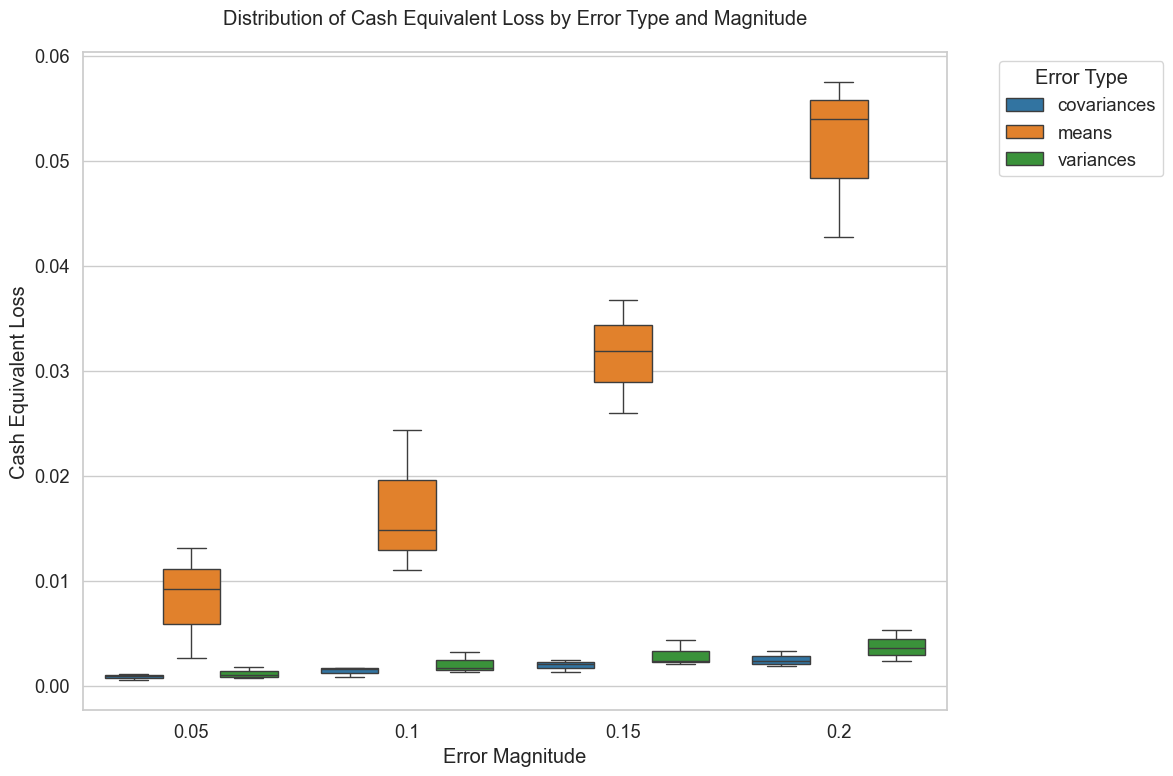

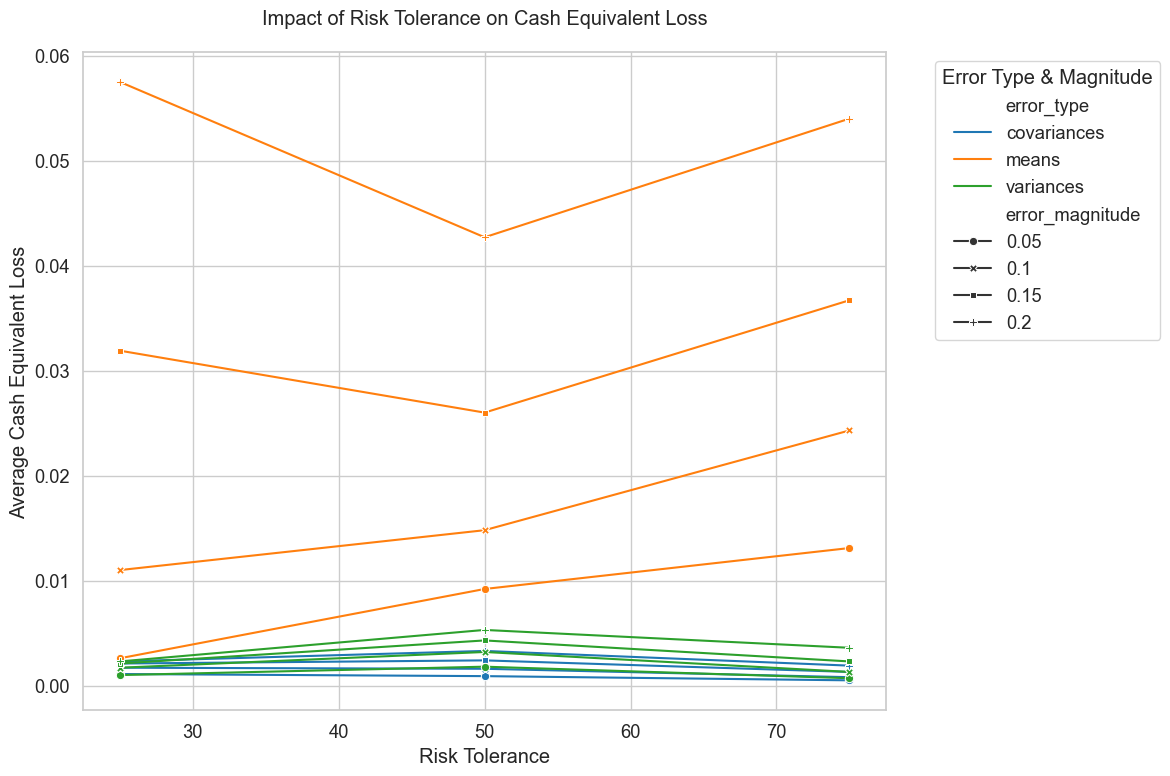

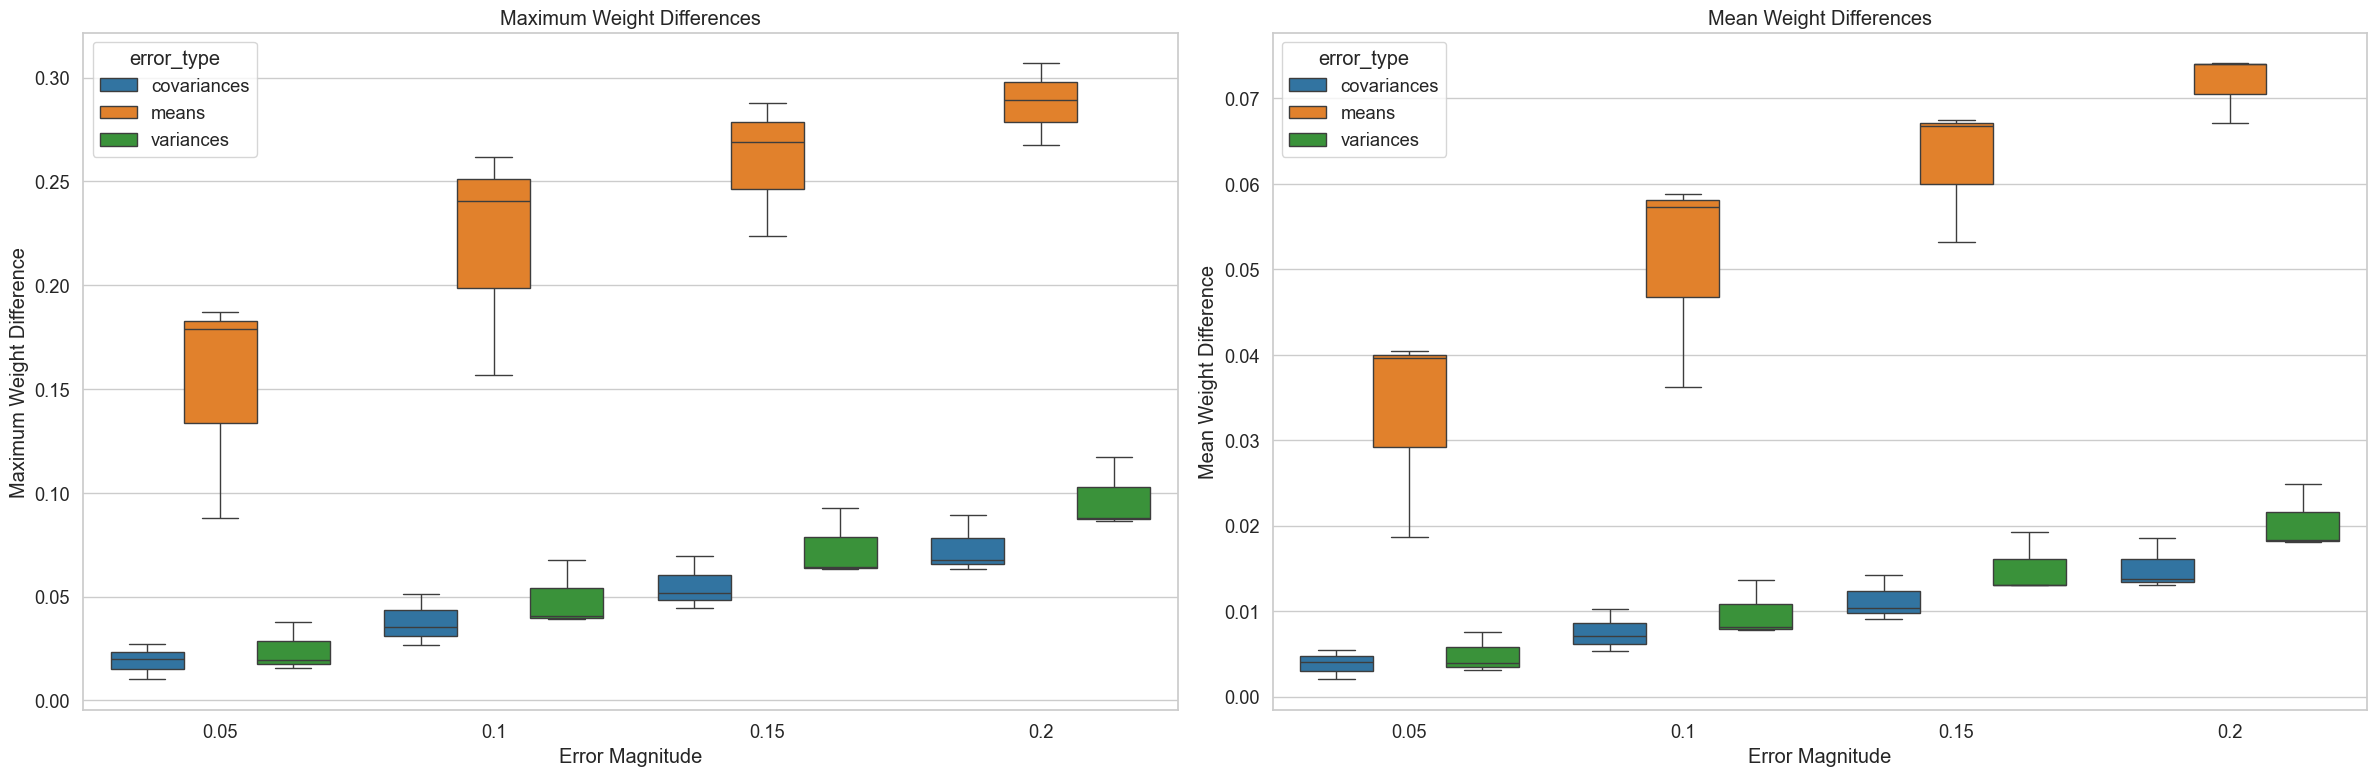

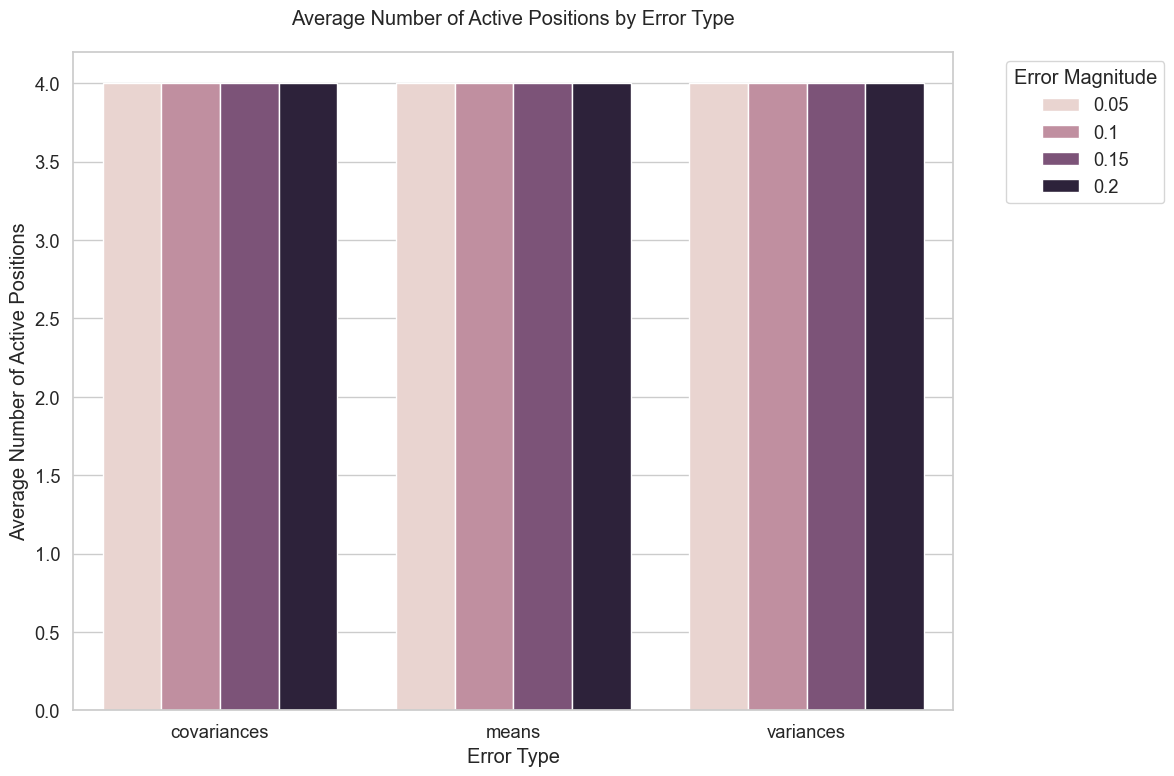

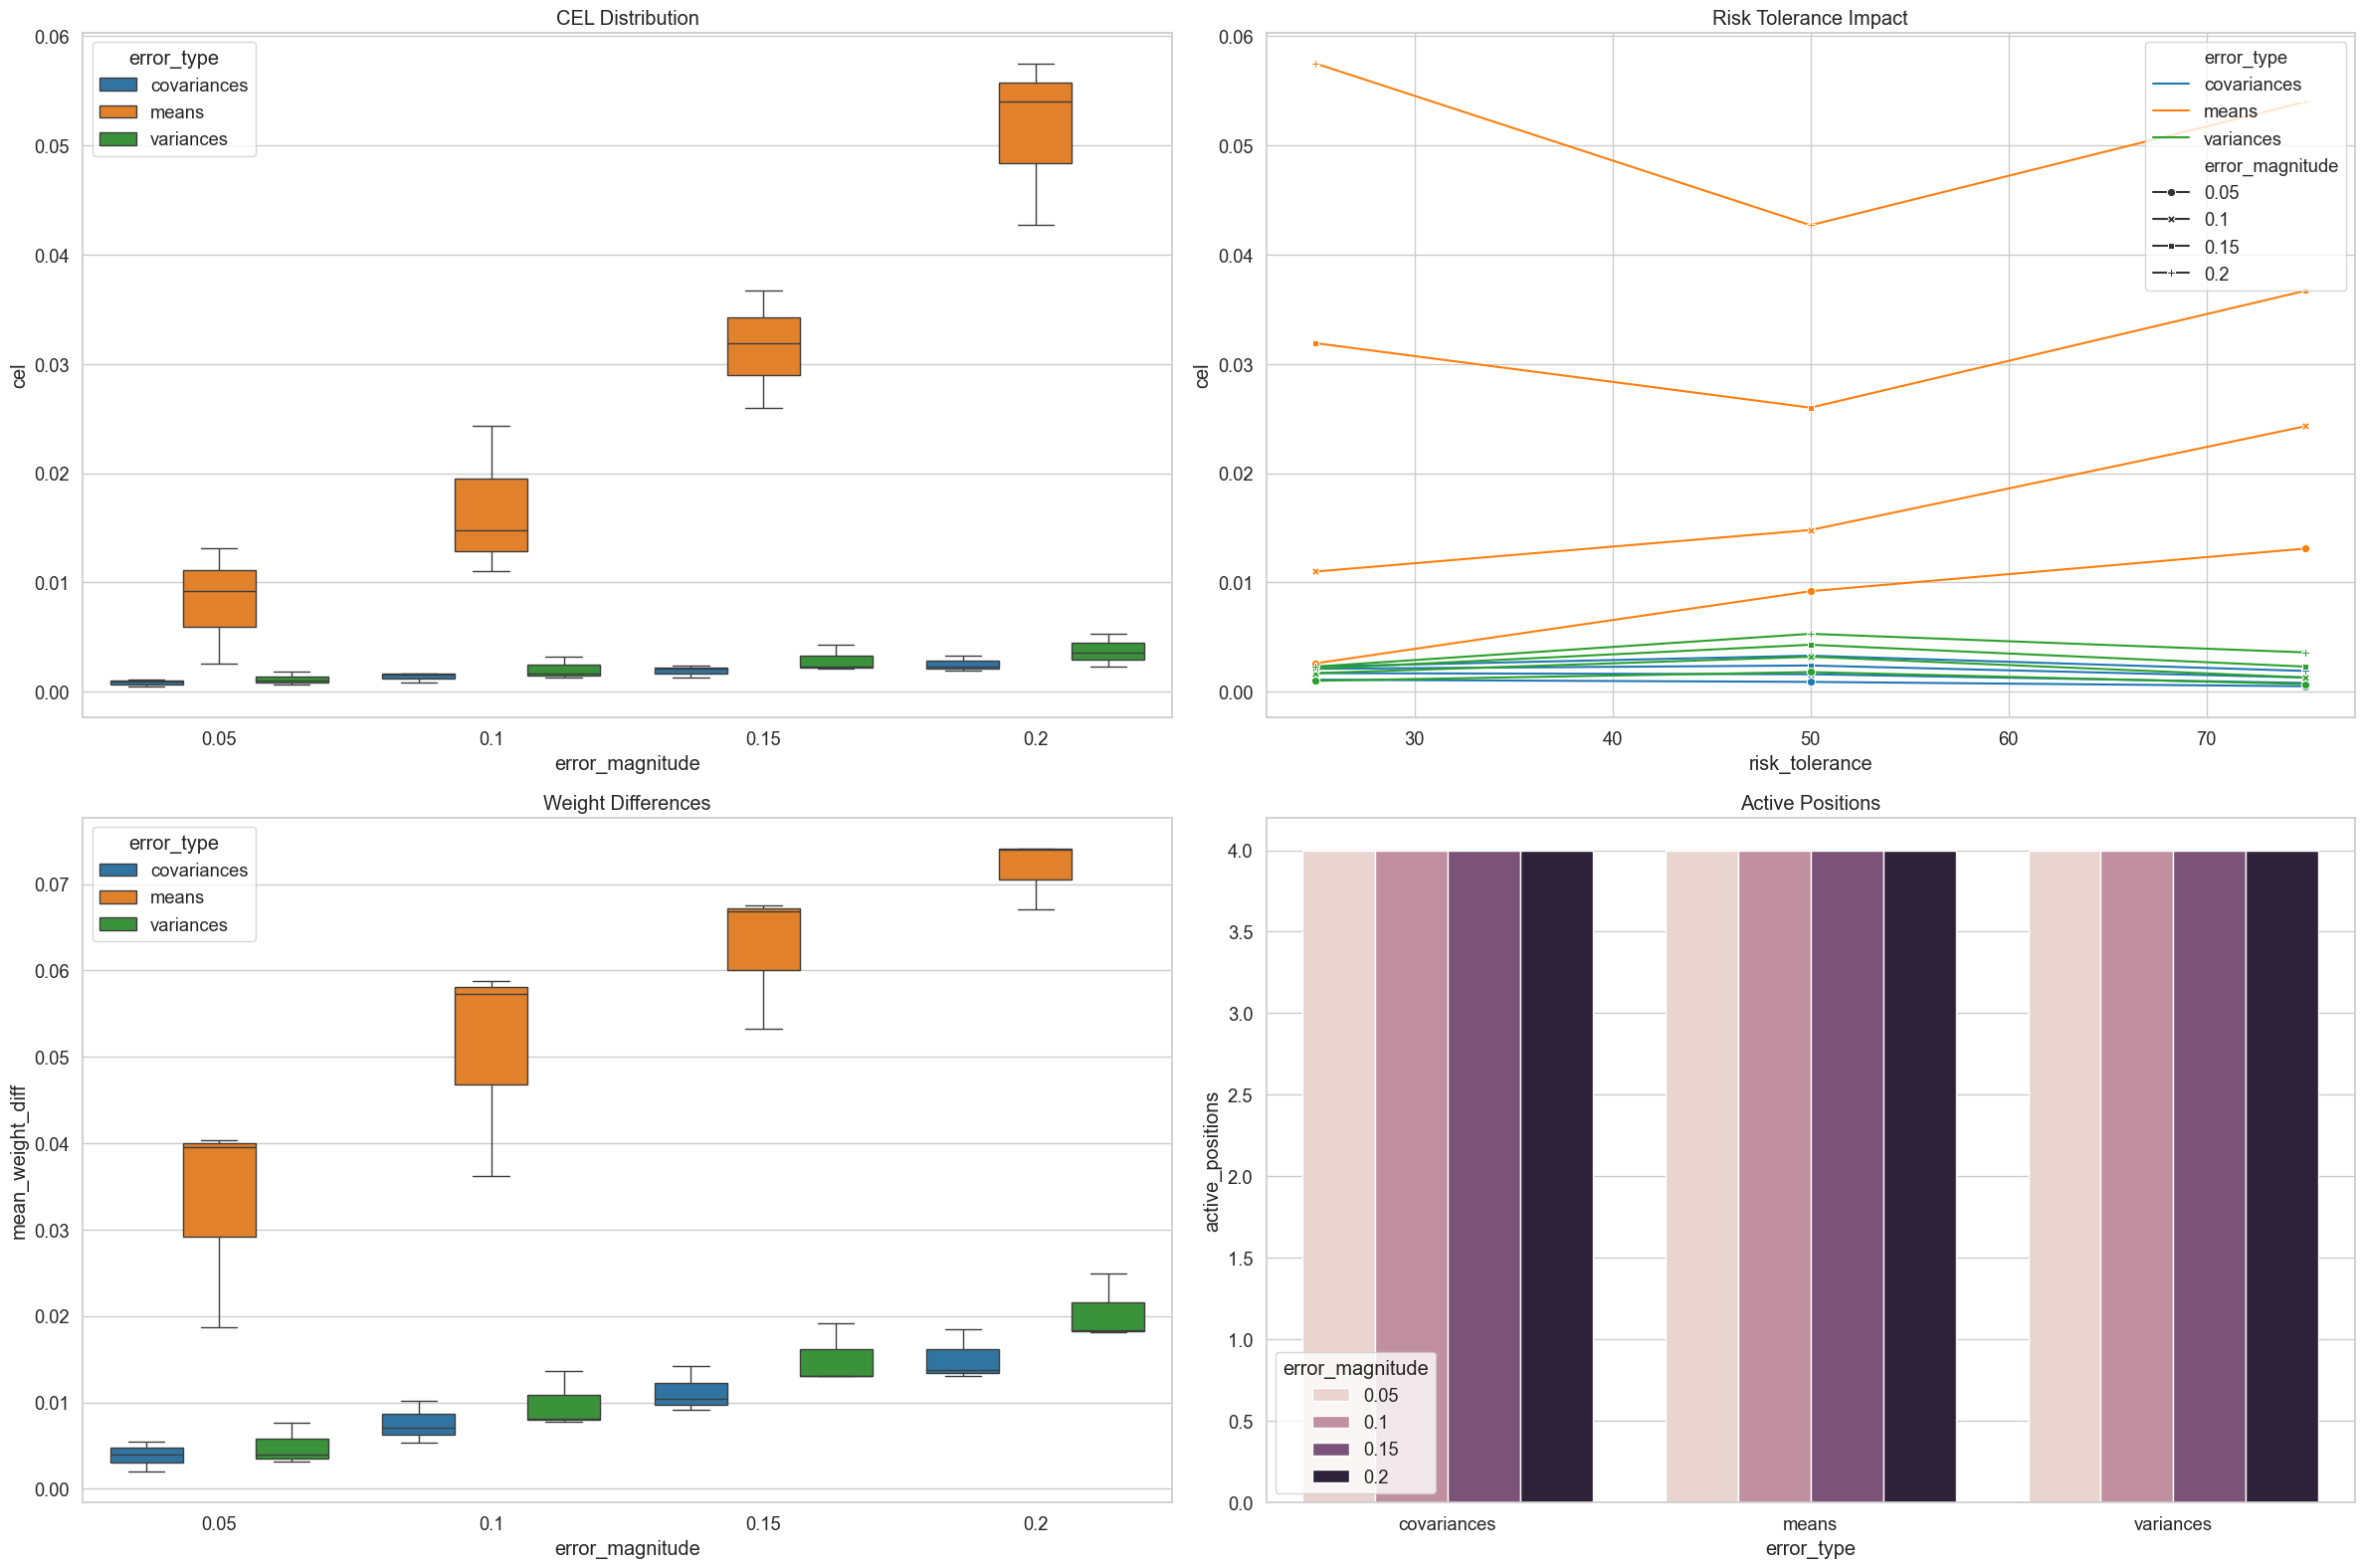

In [22]:
from src.visualization import create_visualizer

# Crear el visualizador
visualizer = create_visualizer(save_dir='figures')

# Generar todas las visualizaciones
all_plots = visualizer.generate_all_plots(results)

# O generar visualizaciones específicas
cel_vs_error = visualizer.plot_cel_vs_error_magnitude(results)
cel_ratios = visualizer.plot_cel_ratios(results)
paper_dashboard = visualizer.create_paper_style_dashboard(results)

2024-11-30 09:27:25,612 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-11-30 09:27:25,614 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-11-30 09:27:26,006 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-11-30 09:27:26,023 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-11-30 09:27:31,

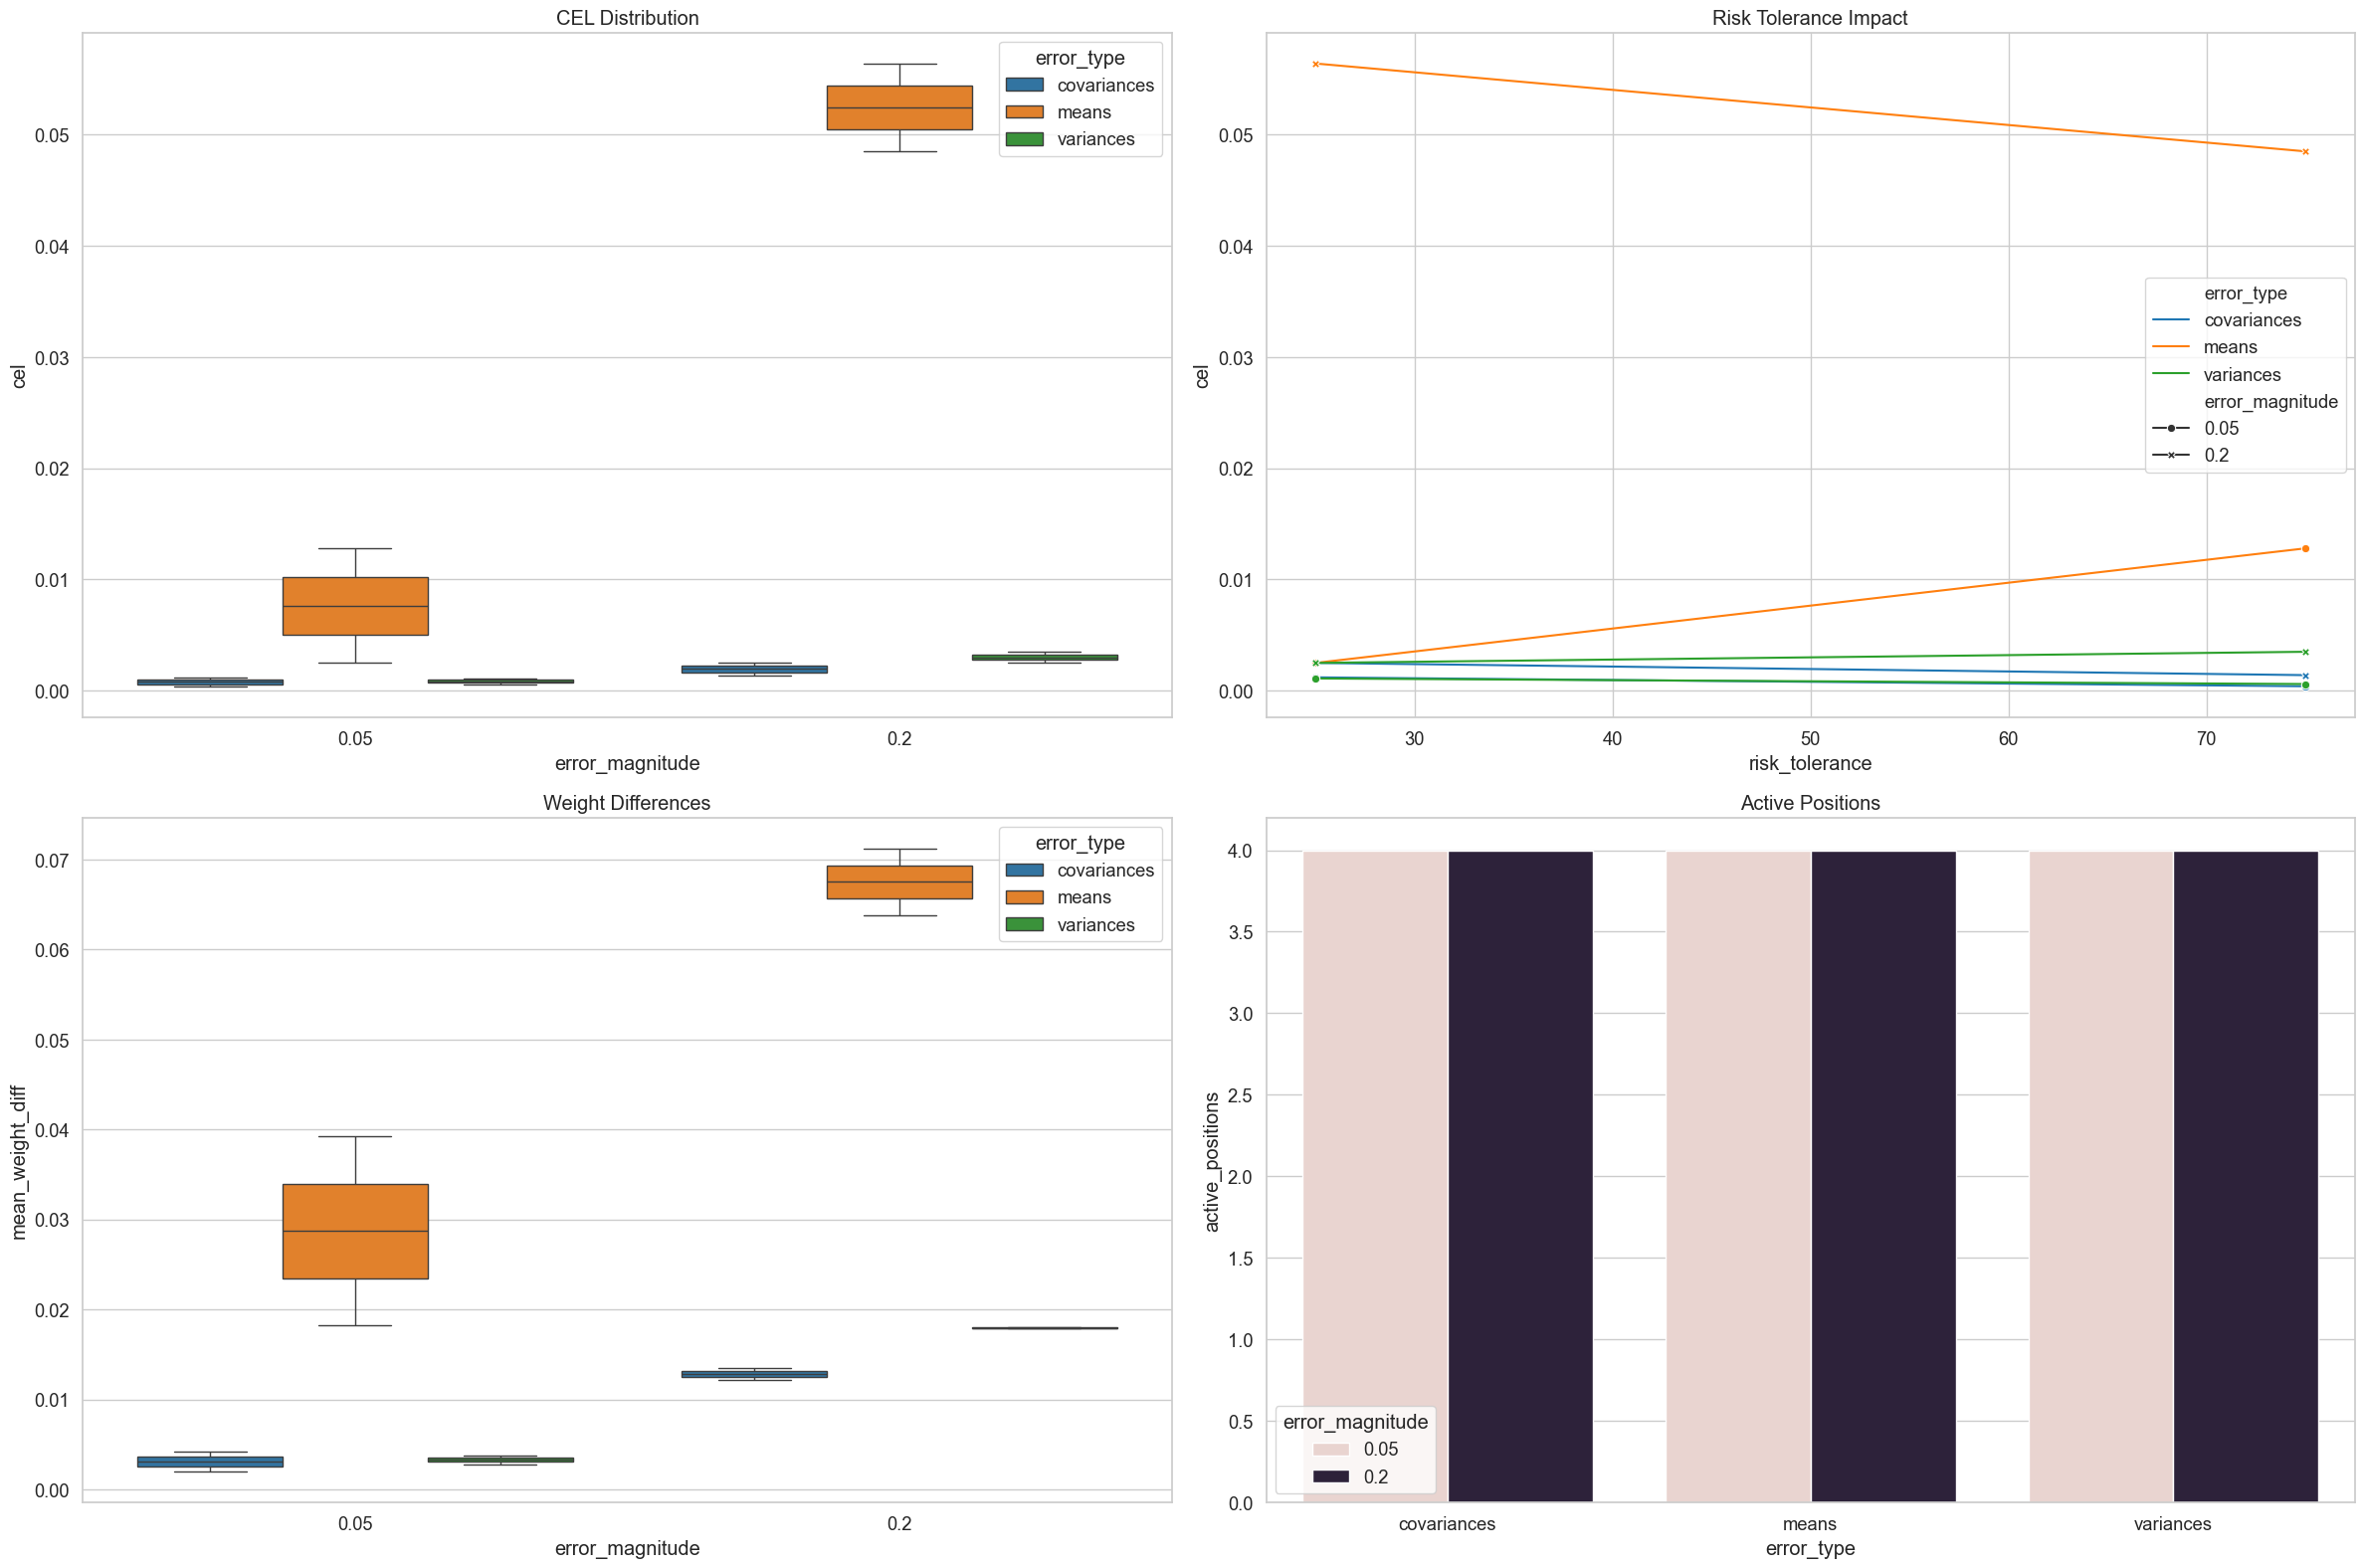

In [11]:
# Generar dashboard resumen
dashboard = visualizer.create_summary_dashboard(results)

## 5. Analysis of Results
Let's analyze the key findings from our error analysis:


In [23]:
# Calculate detailed summary statistics
summary_stats = pd.DataFrame({
    'Error Type': results.index.get_level_values('error_type'),
    'Error Magnitude': results.index.get_level_values('error_magnitude'),
    'Risk Tolerance': results.index.get_level_values('risk_tolerance'),
    'Mean CEL': results[('cel', 'mean')],
    'Max CEL': results[('cel', 'max')],
    'Mean Weight Diff': results[('mean_weight_diff', 'mean')],
    'Return Difference': results[('suboptimal_return', 'mean')] - results[('optimal_return', 'mean')],
    'Risk Difference': results[('suboptimal_risk', 'mean')] - results[('optimal_risk', 'mean')]
}).round(4)

# Group by error type and magnitude
grouped_stats = summary_stats.groupby(['Error Type', 'Error Magnitude']).mean()
print("\nDetailed Summary Statistics:")
print(grouped_stats)

KeyError: ('suboptimal_return', 'mean')